##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

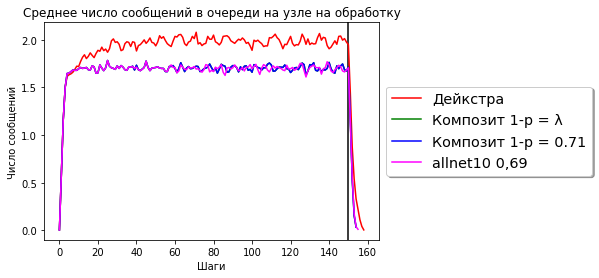

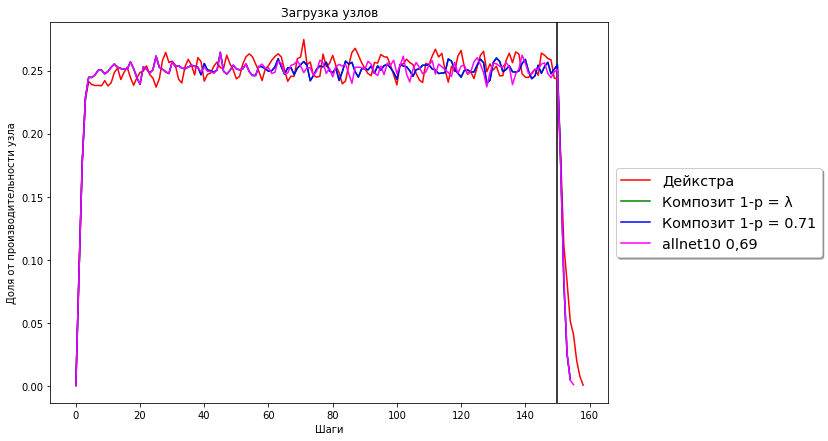

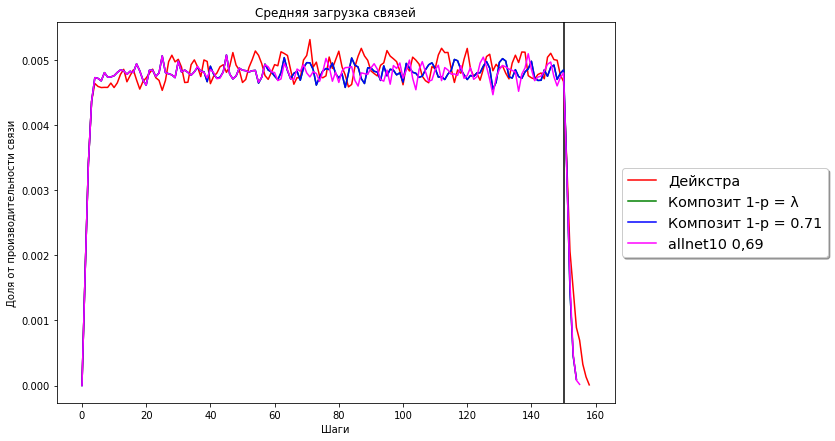

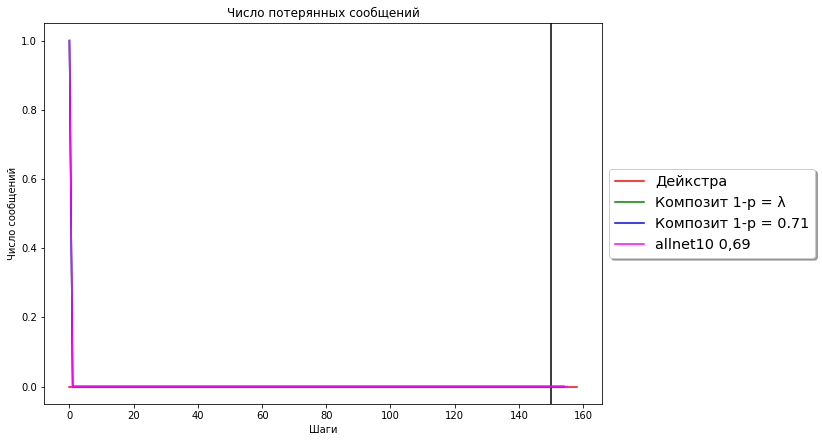

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.71
Доставлено 15000 Потеряно 0.0067% -allnet10 0,69


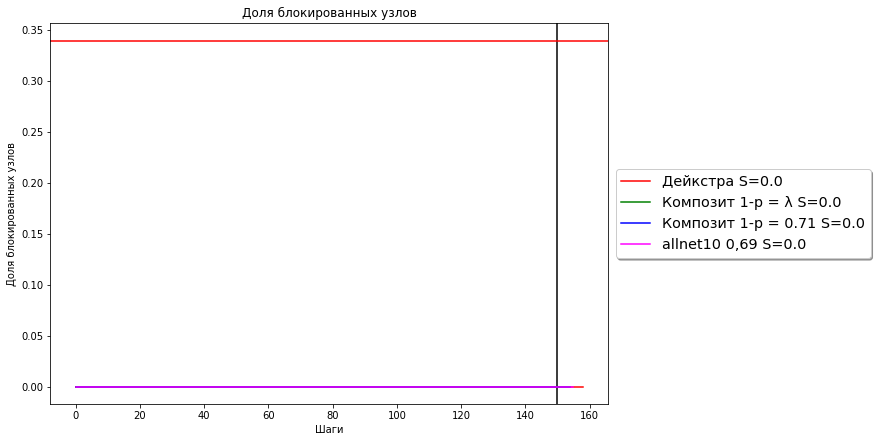

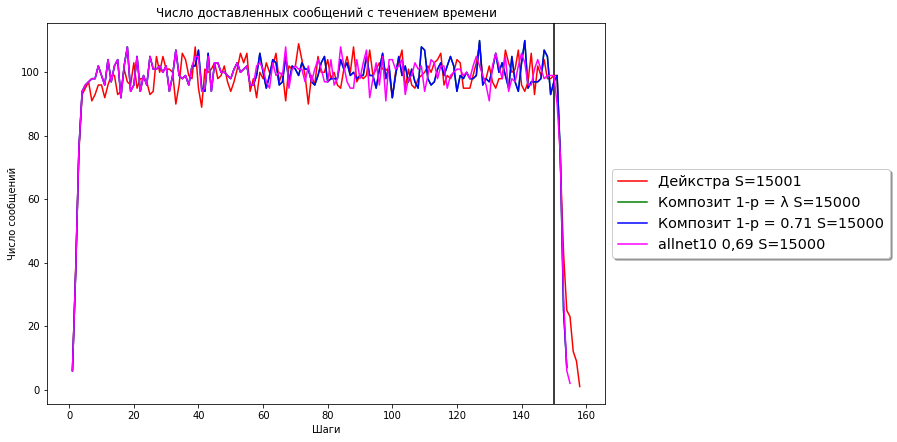

In [2]:
log_tags = [
 {"tag":  "fd807620-1693-4006-8ce5-5a4f0a54c078", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "7746585c-af6e-4499-9ece-476b95d80554", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "9e6e51fa-4880-454a-93d7-41f57bb5efbc", "label": "Композит 1-p = 0.71", "color": "blue"},
{"tag":  "2239011d-88bf-4f81-9f9a-51aa59a7766f", "label": "allnet10 0,69", "color": "magenta"},
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

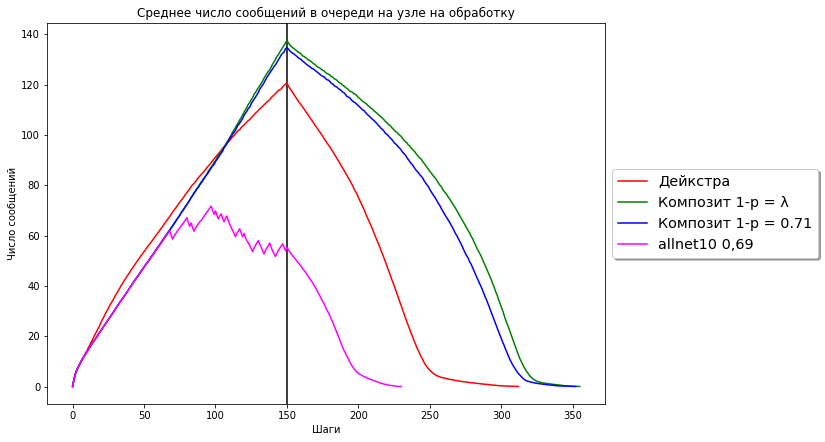

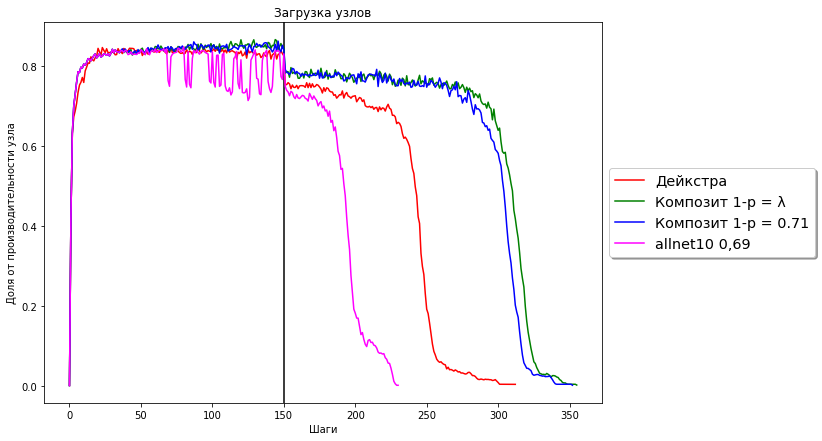

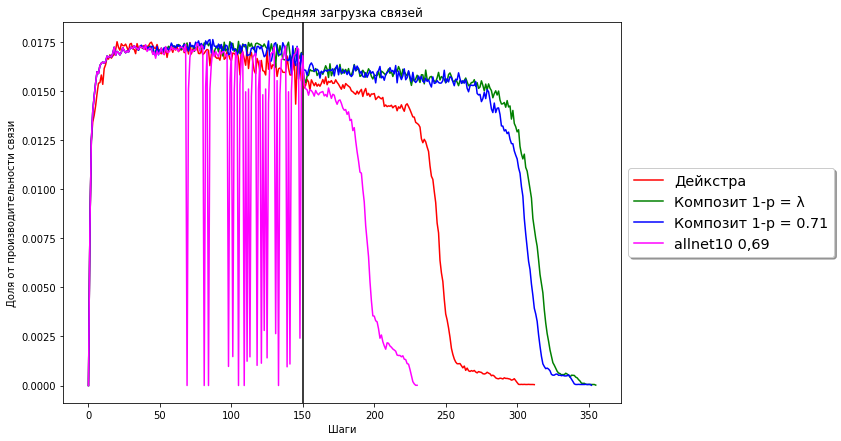

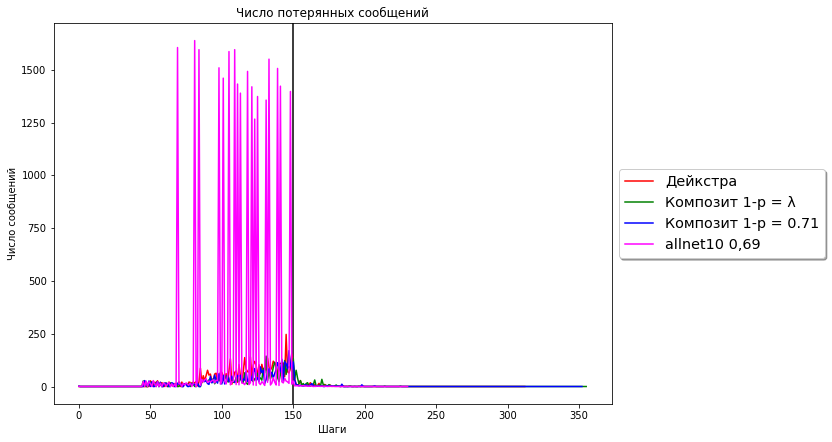

Доставлено 69270 Потеряно 7.6412% -Дейкстра
Доставлено 71086 Потеряно 5.2199% -Композит 1-p = λ
Доставлено 71120 Потеряно 5.1746% -Композит 1-p = 0.71
Доставлено 46958 Потеряно 37.3902% -allnet10 0,69


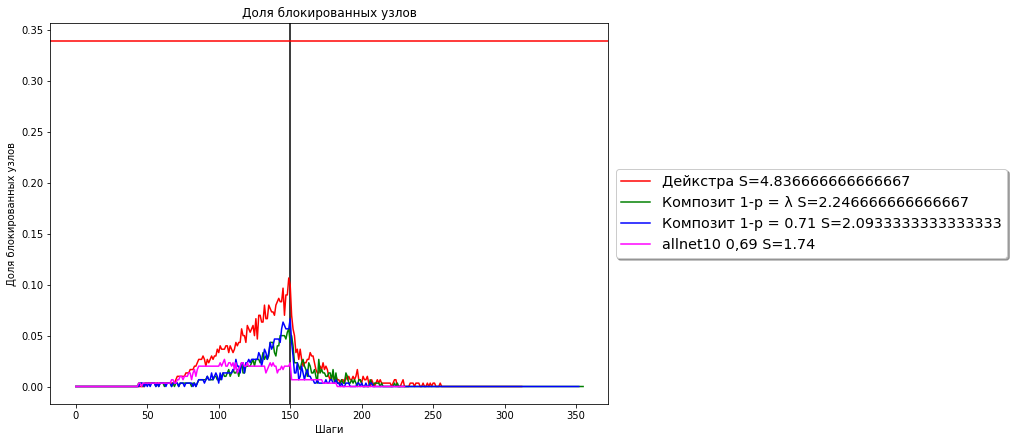

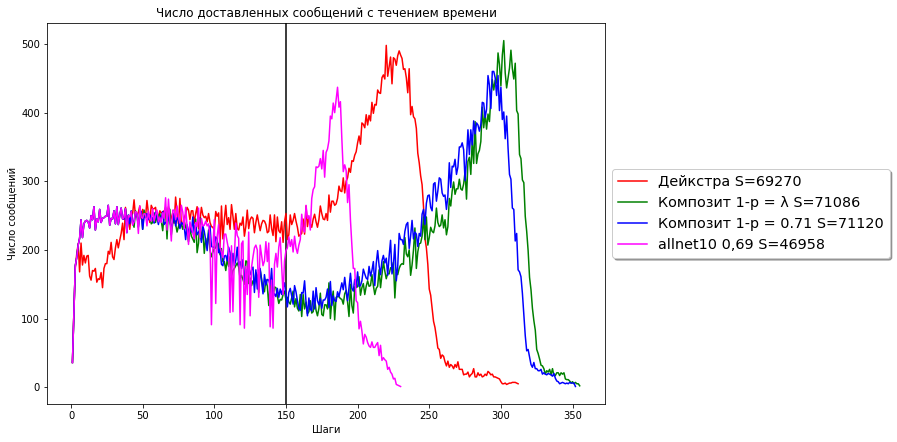

In [3]:
log_tags = [
 {"tag":  "640ae041-3022-4200-a725-32ae0058a319", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "1b4a3689-2f70-4d97-baec-961618643d36", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "6e6d37fe-3055-4549-9b49-3f96579b3a8a", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "0ca7a922-e8a4-43db-a1fb-2cfcf1a9da67", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

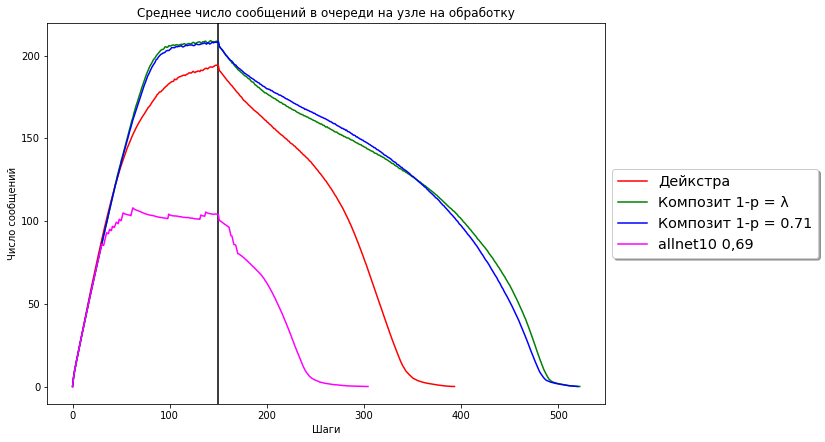

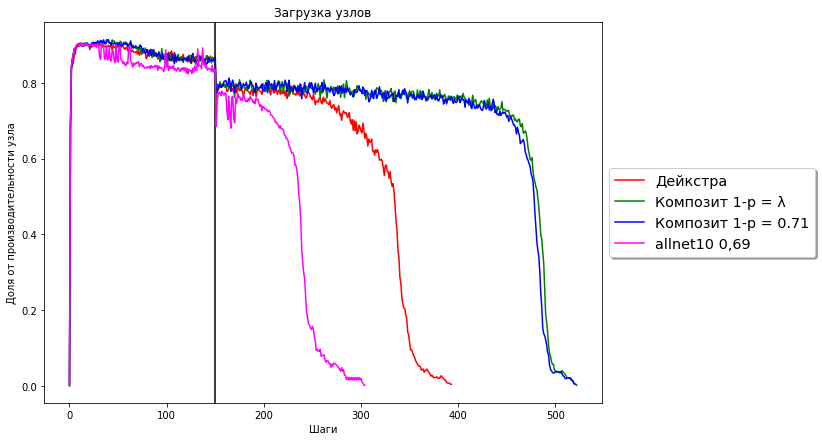

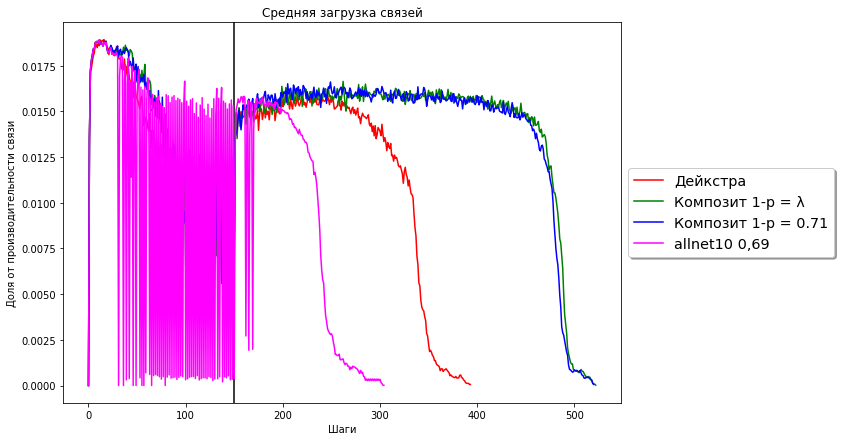

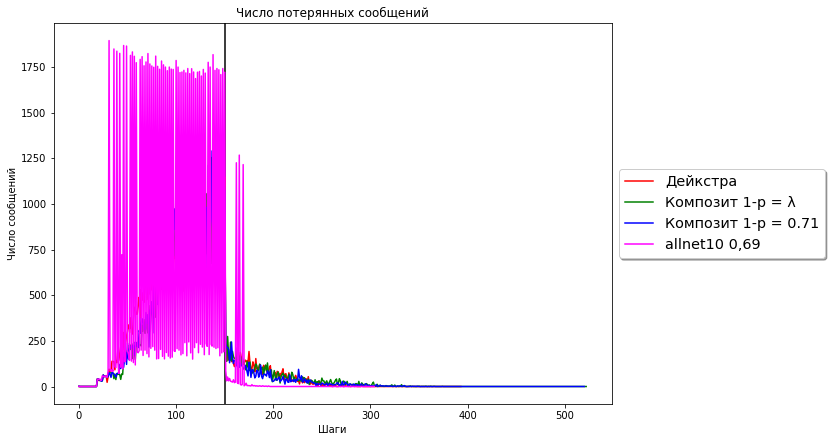

Доставлено 67258 Потеряно 55.1616% -Дейкстра
Доставлено 67480 Потеряно 55.0136% -Композит 1-p = λ
Доставлено 69723 Потеряно 53.5183% -Композит 1-p = 0.71
Доставлено 39519 Потеряно 73.6542% -allnet10 0,69


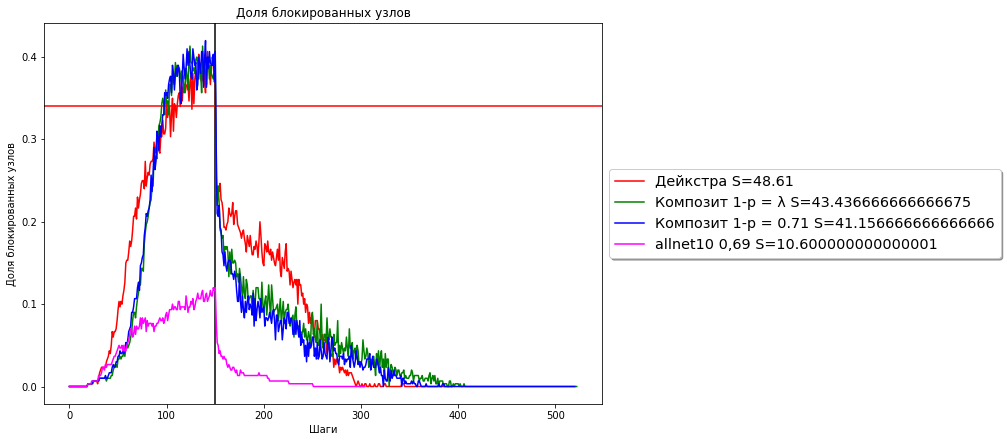

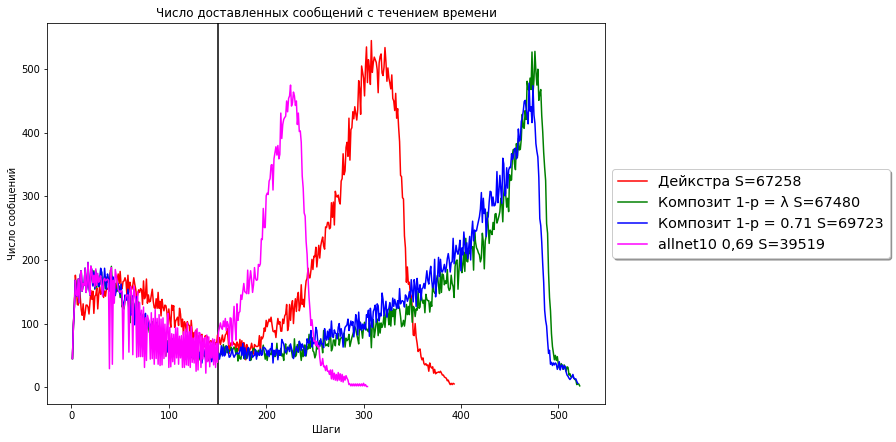

In [4]:
log_tags = [
 {"tag":  "4a24a458-fe46-4328-a6e9-4f9c77064135", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "00472abe-a252-4888-9bb2-25f3563b8986", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "ed7454e4-cce5-42f9-a586-f0675cea114a", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "a04e6cf2-902b-44d8-a2af-18c78b134354", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

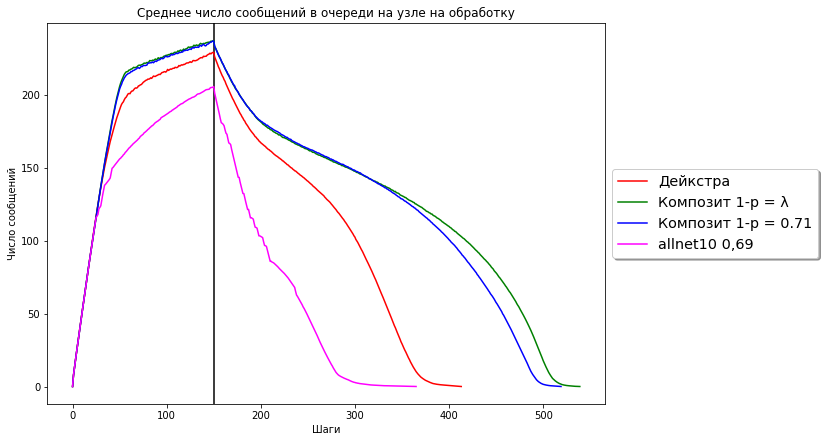

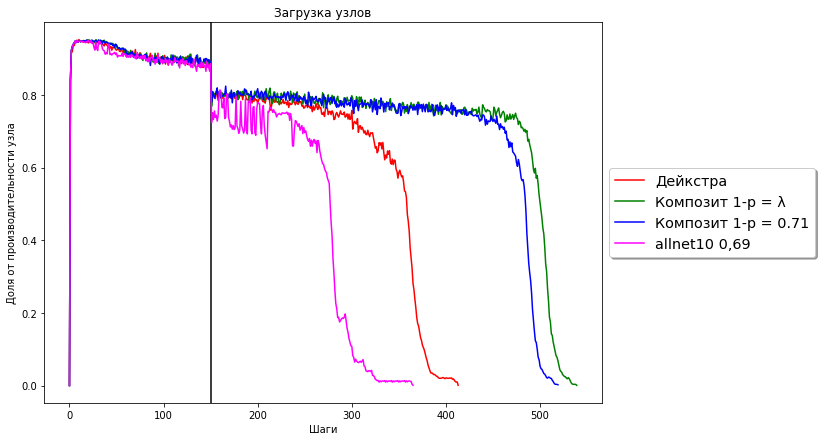

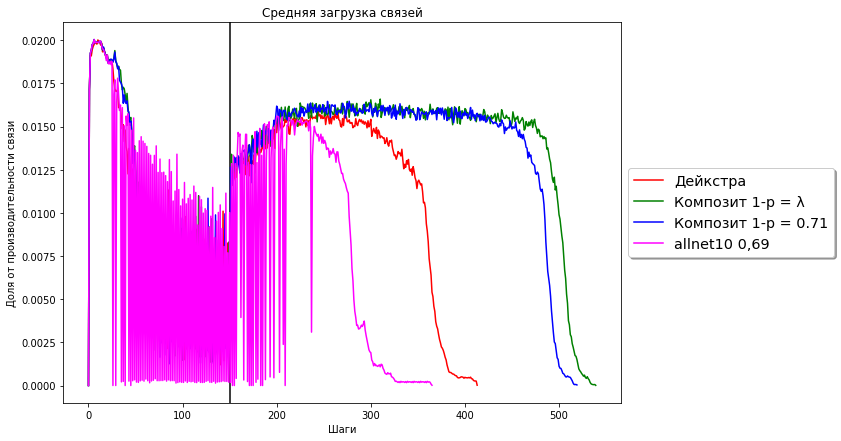

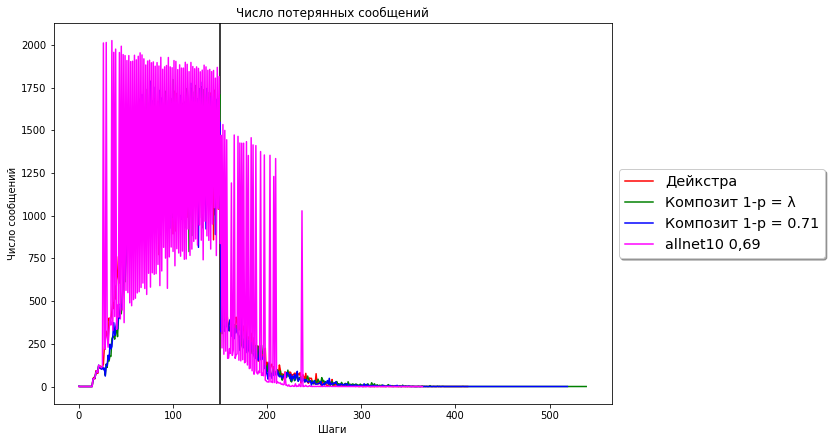

Доставлено 59595 Потеряно 73.5135% -Дейкстра
Доставлено 62452 Потеряно 72.2437% -Композит 1-p = λ
Доставлено 63598 Потеряно 71.7343% -Композит 1-p = 0.71
Доставлено 35514 Потеряно 84.2161% -allnet10 0,69


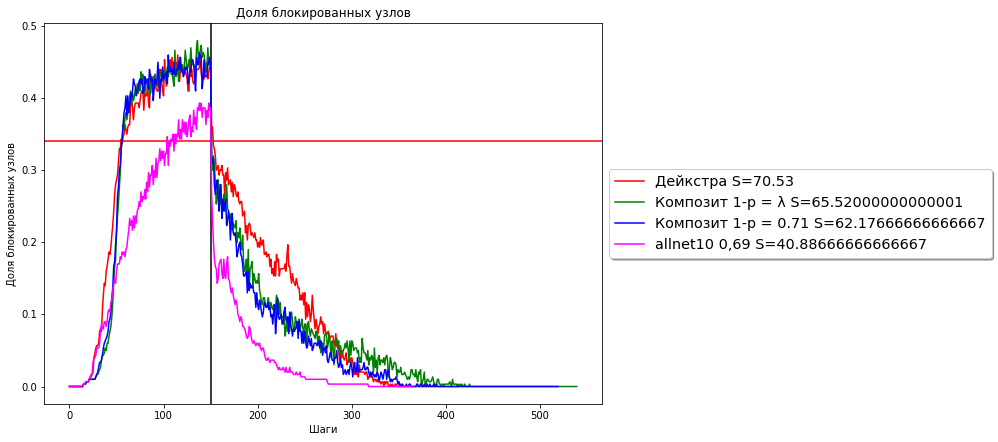

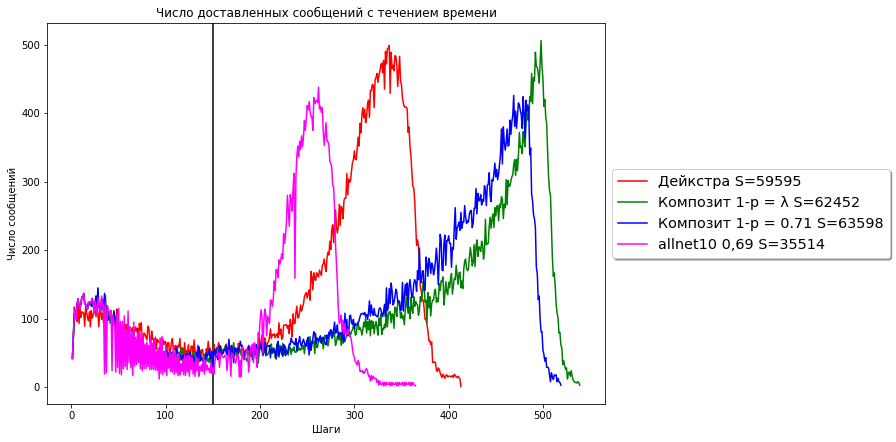

In [5]:
log_tags = [
 {"tag":  "ead4b6cb-3d74-49c7-bd3b-c959631b07ec", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "b4ce1d69-1ebb-488d-816e-a842ccde28e9", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "04bf768c-37ac-458c-bbfe-2ff56984a5a8", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "072b6bfa-1cb6-42da-bd7b-a19b92f0863d", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 44423 Потеряно 1.2844% -Дейкстра
Доставлено 44431 Потеряно 1.2666% -Композит 1-p = λ
Доставлено 44428 Потеряно 1.2733% -Композит 1-p = 0.71
Доставлено 44434 Потеряно 1.2600% -allnet10 0,69


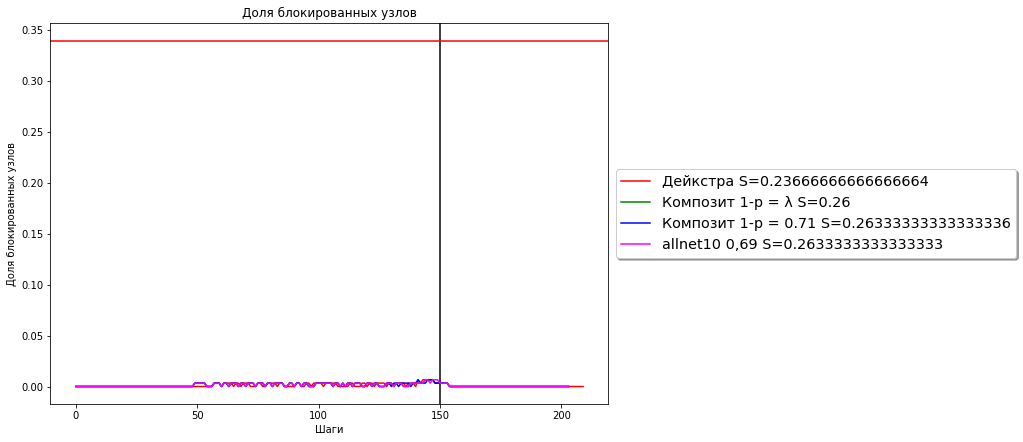

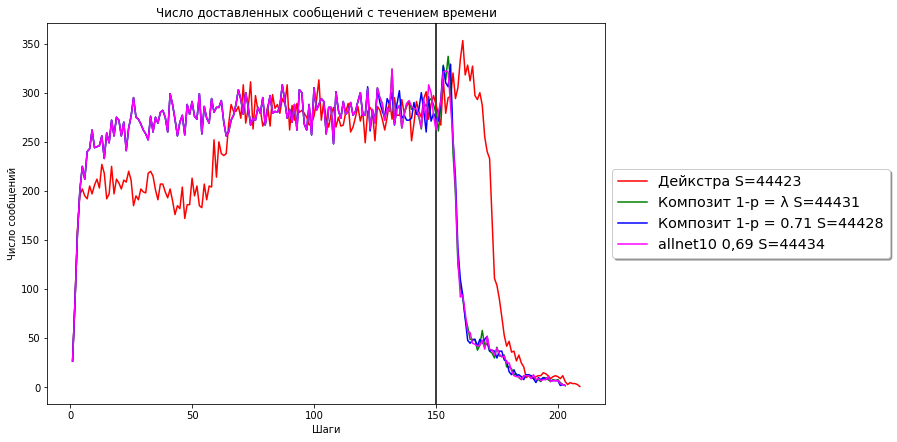

Доставлено 74598 Потеряно 28.9550% -Дейкстра
Доставлено 74596 Потеряно 28.9569% -Композит 1-p = λ
Доставлено 76710 Потеряно 26.9436% -Композит 1-p = 0.71
Доставлено 38128 Потеряно 63.6880% -allnet10 0,69


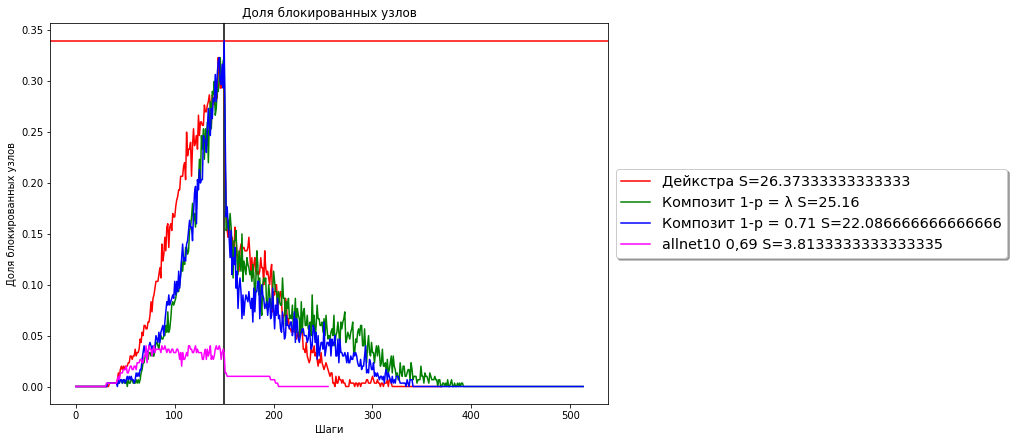

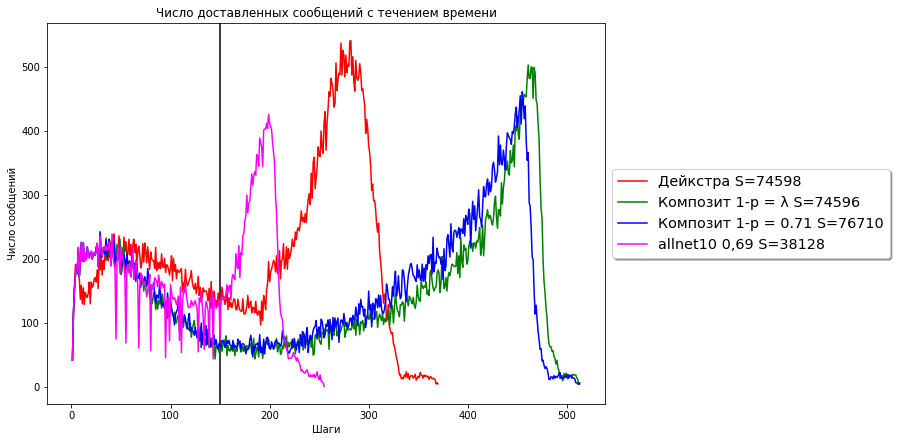

Доставлено 69651 Потеряно 48.4070% -Дейкстра
Доставлено 69557 Потеряно 48.4767% -Композит 1-p = λ
Доставлено 71388 Потеряно 47.1204% -Композит 1-p = 0.71
Доставлено 37991 Потеряно 71.8587% -allnet10 0,69


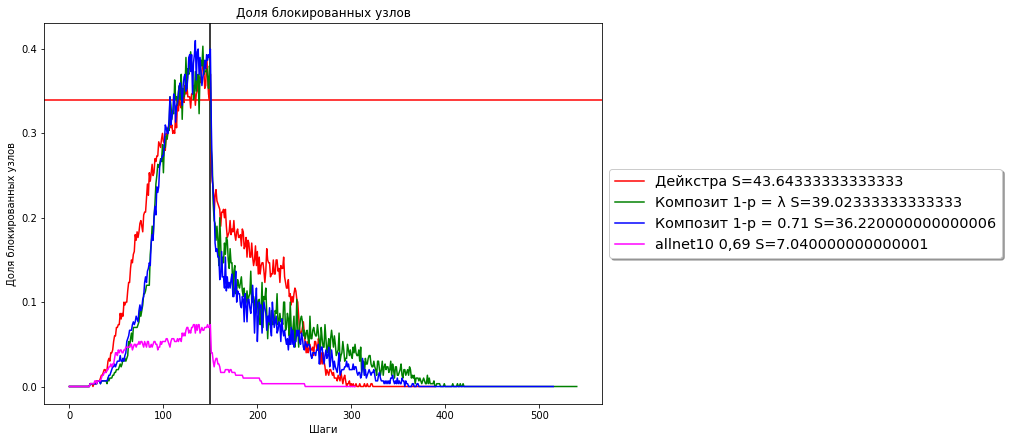

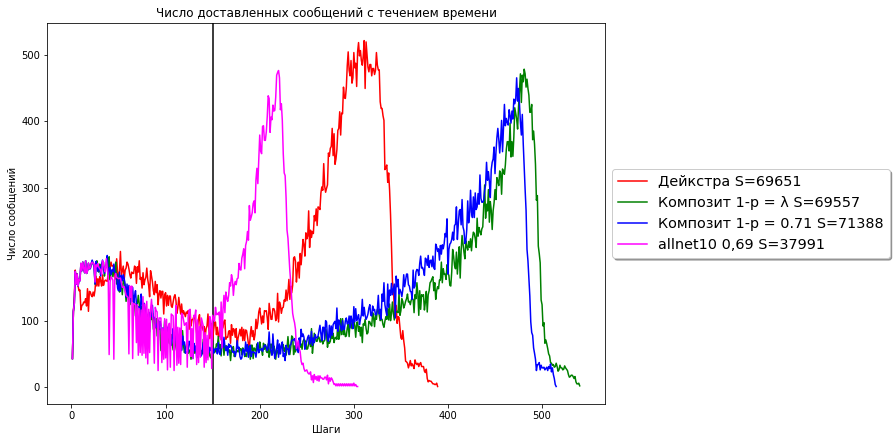

Доставлено 63643 Потеряно 64.6430% -Дейкстра
Доставлено 64928 Потеряно 63.9291% -Композит 1-p = λ
Доставлено 67132 Потеряно 62.7047% -Композит 1-p = 0.71
Доставлено 38257 Потеряно 78.7462% -allnet10 0,69


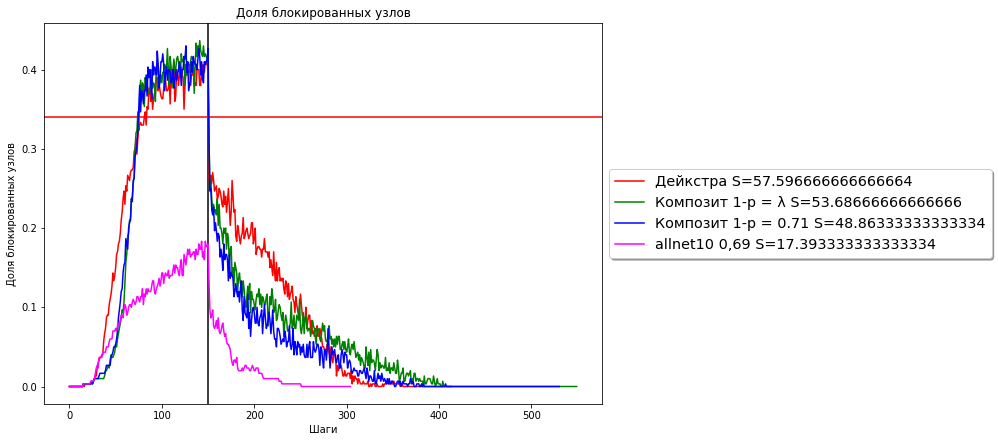

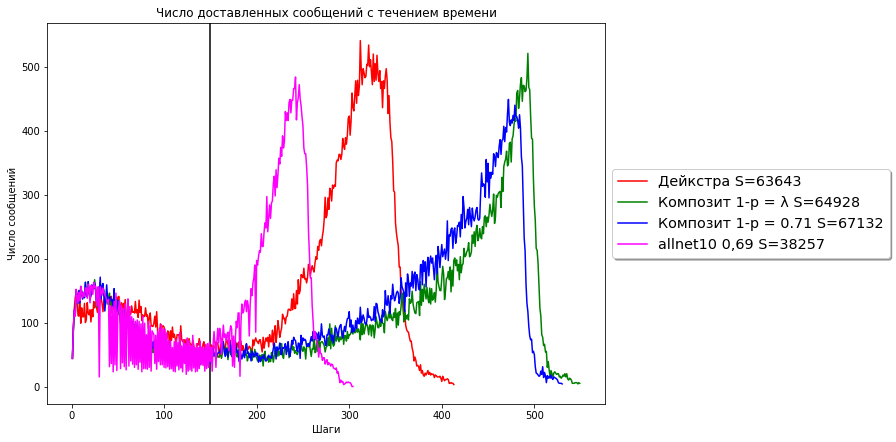

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "36ef69e2-e8ae-4d27-9e98-1aae7465b6af", "label": "Дейкстра", "color": "red"},
 {"tag":  "9eb91b28-60c2-4fca-b8c2-a2cf1f0ba761", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7a68f426-91ae-421c-9aaf-ca66ddff6fb7", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "a2729142-ad1f-4b1a-b263-95258a3511ab", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "7e67b9c3-0812-4133-a095-9ff073f9c50a", "label": "Дейкстра", "color": "red"},
 {"tag":  "66d37fba-42d6-4a1a-94b8-ecfb9c5eee55", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2fe5d7b0-fc3e-490d-8ea7-3a12e14a1296", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "057a1fa1-74f1-4049-a143-d827971f8041", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "b50c8670-12d8-40c7-9ba0-6cbfcb306400", "label": "Дейкстра", "color": "red"},
 {"tag":  "cd4ee910-786f-4e47-8786-bd177f70d2b3", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "02119e35-0f34-438a-a2c1-aba054759c08", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "a1f882fd-3a9e-427d-aa5a-a7887d681636", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 1200;  
log_tags = [
 {"tag":  "800991d7-4499-4860-8d72-a95bf87dbef1", "label": "Дейкстра", "color": "red"},
 {"tag":  "3b47fd32-a561-44ea-9bb5-04334d4294ce", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "edbc4b32-57be-40f3-bb3c-43392709976b", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "4542d762-eaa6-47c8-b3b7-9b239d752525", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

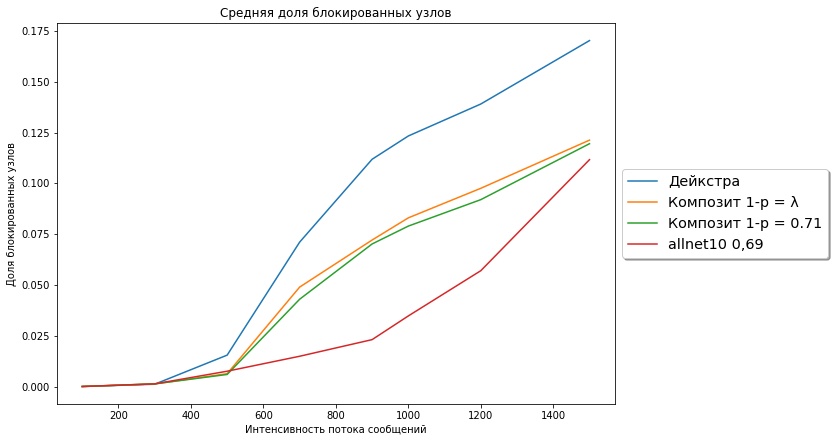

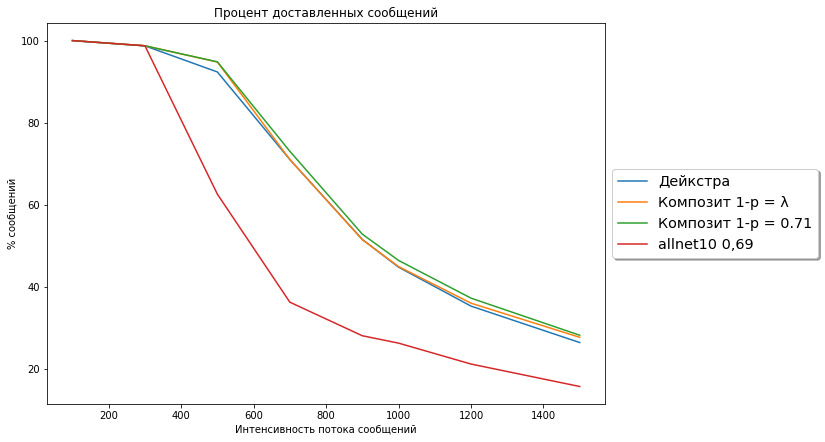

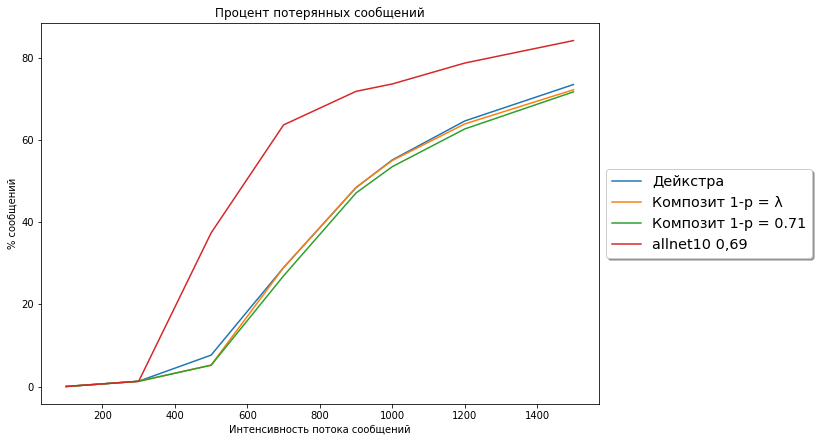

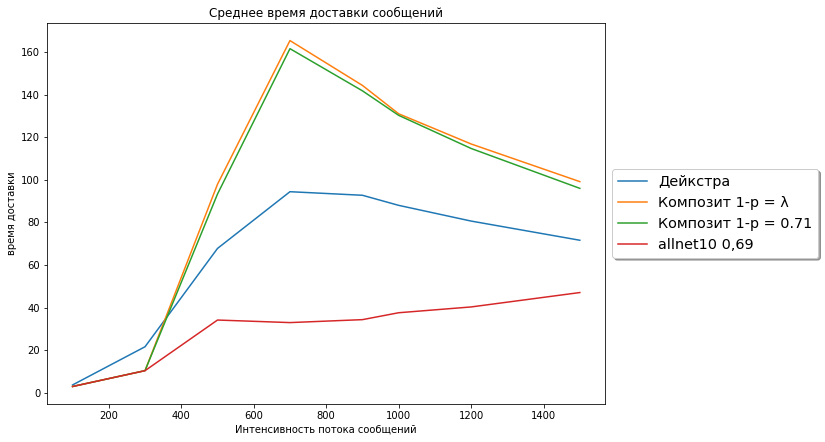

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.079054
Композит 1-p = λ       0.053833
Композит 1-p = 0.71    0.051372
allnet10 0,69          0.031287

Дейкстра               34.950715
Композит 1-p = λ       34.389148
Композит 1-p = 0.71    33.559478
allnet10 0,69          51.352497

Дейкстра               65.091052
Композит 1-p = λ       96.012836
Композит 1-p = 0.71    93.897988
allnet10 0,69          30.005282
